In this notebook, I perform exploratory data analysis to better understand the data. I then use machine learning techniques to predict price, using all of the price data.

In [1]:
#Basics
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#Plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
from PIL import Image as im
from IPython.display import Image
from scipy import stats

#Wordcloud packages
from os import path
from PIL import Image
from IPython.display import SVG, display
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re 
import collections as c

#Modelling
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import joblib
import os


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Data Cleaning 

In [3]:
#Importing data
ny_df = pd.read_csv('capstone_data/new-york-city-airbnb-open-data/AB_NYC_2019.csv')
ny_df.head()
#ny_df.info()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [4]:
#Take a look at naan value percentages
missing_data_summary = (ny_df.isnull().sum()/len(ny_df))*100
missing_data_summary
#looks like if there are no reviews then last review and reviews per month are both NaN

id                                 0.000000
name                               0.032723
host_id                            0.000000
host_name                          0.042949
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       20.558339
reviews_per_month                 20.558339
calculated_host_listings_count     0.000000
availability_365                   0.000000
dtype: float64

In [5]:
#dropping rows with nan would mean losing 20% of our data, but dropping the columns would be a loss of a possibly important predictor
ny_df[ny_df.isna()["reviews_per_month"]]
reviews_per_month_no_nan=ny_df[ny_df.notnull()["reviews_per_month"]]
reviews_per_month_no_nan.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
5  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   
5        Chris           Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   
5  Entire home/apt    200               3                 74  2019-06-22   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
3               4.64                               1               194  
4               0.10                               1                 0  
5               0.59                               1               129

In [6]:
#Lets replace the nan values in the reviews_per_month with 0 and drop the last_review  column
ny_df["reviews_per_month"] = ny_df["reviews_per_month"].fillna(0)
ny_df.drop('last_review', axis=1, inplace=True)

In [7]:
#Now lets deal with the missing names and host names. Since we might want to use names later, we wont drop
#We also want to get rid of NaN values, so we'll replace NaN with Unkown 

ny_df["name"] = ny_df["name"].fillna("Unknown")
ny_df["host_name"] = ny_df["name"].fillna("Unknown")


In [8]:
#making sure we don't have any nan values left 
missing_data_summary = (ny_df.isnull().sum()/len(ny_df))*100
missing_data_summary

id                                0.0
name                              0.0
host_id                           0.0
host_name                         0.0
neighbourhood_group               0.0
neighbourhood                     0.0
latitude                          0.0
longitude                         0.0
room_type                         0.0
price                             0.0
minimum_nights                    0.0
number_of_reviews                 0.0
reviews_per_month                 0.0
calculated_host_listings_count    0.0
availability_365                  0.0
dtype: float64

In [9]:
#Moving price to the end of the dataframe
ny_df.columns
ny_df=ny_df[['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365','price']]

In [10]:
#Take a look at the continuous data in our dataframe
display(ny_df.describe())

id       host_id      latitude     longitude  minimum_nights  \
count  4.889500e+04  4.889500e+04  48895.000000  48895.000000    48895.000000   
mean   1.901714e+07  6.762001e+07     40.728949    -73.952170        7.029962   
std    1.098311e+07  7.861097e+07      0.054530      0.046157       20.510550   
min    2.539000e+03  2.438000e+03     40.499790    -74.244420        1.000000   
25%    9.471945e+06  7.822033e+06     40.690100    -73.983070        1.000000   
50%    1.967728e+07  3.079382e+07     40.723070    -73.955680        3.000000   
75%    2.915218e+07  1.074344e+08     40.763115    -73.936275        5.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990     1250.000000   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
count       48895.000000       48895.000000                    48895.000000   
mean           23.274466           1.090910                        7.143982   
std            44.550582           1.597283                       32.952519   
min             0.000000           0.000000                        1.000000   
25%             1.000000           0.040000                        1.000000   
50%             5.000000           0.370000                        1.000000   
75%            24.000000           1.580000                        2.000000   
max           629.000000          58.500000                      327.000000   

       availability_365         price  
count      48895.000000  48895.000000  
mean         112.781327    152.720687  
std          131.622289    240.154170  
min            0.000000      0.000000  
25%            0.000000     69.000000  
50%           45.000000    106.000000  
75%          227.000000    175.000000  
max          365.000000  10000.000000

When I get to modelling, the distribution of the target (price) will be important to the accuracy. Since the range of price looks high in the plot above, let's visualize what price looks like at different thresholds.  

The mean price is 152.7206871868289
The median price is 106.0
The max price is 10000


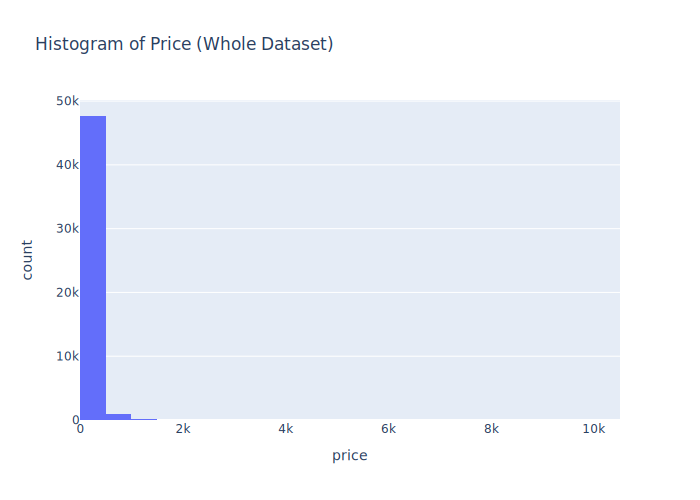

In [11]:

#Lets just take a look at our target, price, to see what kind of distribution it has
fig = px.histogram(ny_df, x="price", nbins=30, title='Histogram of Price (Whole Dataset)')

print(f'The mean price is {ny_df["price"].mean()}')
print(f'The median price is {ny_df["price"].median()}')
print(f'The max price is {ny_df["price"].max()}')
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

The mean price is 140.23729859867893
The median price is 105.0
The max price is 999
Dropping 239 rows, 0.5 percent


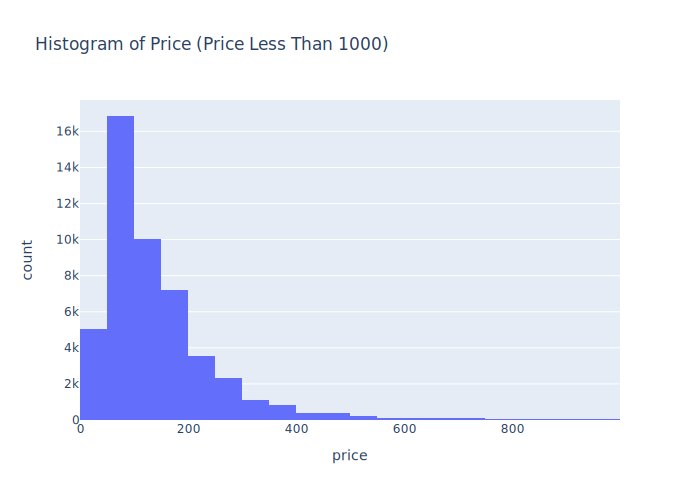

In [12]:
#Lets just take a look at our target, price, to see what kind of distribution it has
fig = px.histogram(ny_df[ny_df["price"]<1000], x="price", nbins=30, title='Histogram of Price (Price Less Than 1000)')

print(f'The mean price is {ny_df[ny_df["price"]<1000]["price"].mean()}')
print(f'The median price is {ny_df[ny_df["price"]<1000]["price"].median()}')
print(f'The max price is {ny_df[ny_df["price"]<1000]["price"].max()}')
print(f'Dropping {len(ny_df[ny_df["price"]>1000])} rows, {round((len(ny_df[ny_df["price"]>1000]))/len(ny_df), 3)*100} percent')
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

The mean price is 107.89774777941831
The median price is 99.0
The max price is 249
Dropping 5208 rows, 10.7 percent


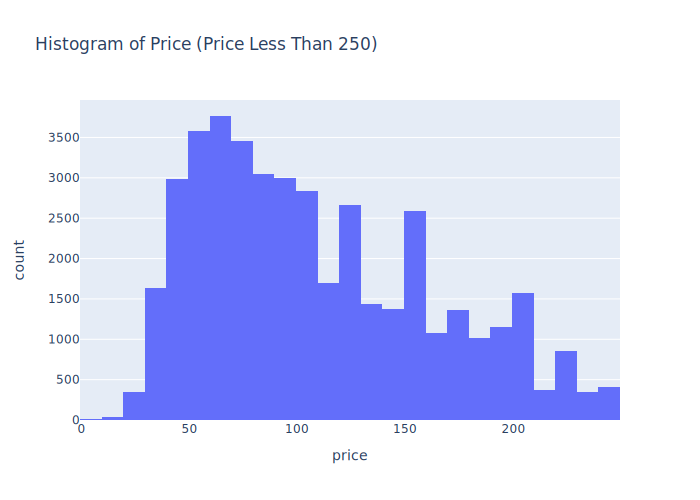

In [13]:
#Lets just take a look at our target, price, to see what kind of distribution it has
fig = px.histogram(ny_df[ny_df["price"]<250], x="price", nbins=30, title='Histogram of Price (Price Less Than 250)')

print(f'The mean price is {ny_df[ny_df["price"]<250]["price"].mean()}')
print(f'The median price is {ny_df[ny_df["price"]<250]["price"].median()}')
print(f'The max price is {ny_df[ny_df["price"]<250]["price"].max()}')
print(f'Dropping {len(ny_df[ny_df["price"]>250])} rows, {round((len(ny_df[ny_df["price"]>250]))/len(ny_df), 3)*100} percent')
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

For this notebook, I will focus on the entire price range. The EDA and modelling results for the bottom 90% of the price range can be found in the notebook "NYC Airbnb Price Prediction -Low Prices". 

## EDA##

In this section, I will visualize the features to better understand the relationships in the data.

In [14]:
#Lets just check some basic correllation properties
ny_df.corr().style.background_gradient(cmap='coolwarm')

### Name EDA

It might be useful to count vectorize the names later on in the analysis, so lets see if there is common verbiage used by hosts in their name/description.

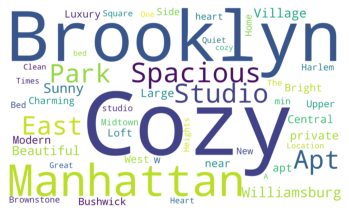

In [15]:
#Lets build a wordcloud of common words used in the "name" column

text = " ".join(name for name in ny_df.name)

whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')

names_concat = ''.join(filter(whitelist.__contains__, text))
names_concat=names_concat.split(" ")

#Creating dictionary of word counts
word_counts={}
for i in names_concat:
    if i not in word_counts:
        word_counts[i]=0
    word_counts[i]+=1

#Get rid of words with little meaning
stopwords = set(STOPWORDS)
stopwords.update(["Room", "Bedroom", "Private", "In", "in", "NYC", "apartment", "room", "bedroom", "br", "Apartment", "BR", " "])

#Get rid of stopwords in our dictionary
for i in stopwords:
    if i in word_counts:
        del word_counts[i]

#Use dictionary to build wordcloud 
wordcloud = WordCloud(background_color="white", width=5000, height=3000, max_words=50).generate_from_frequencies(word_counts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


One explanatory variable that would be helpful to our data would be number of bedrooms. Although we have a room type field, understanding the number of bedrooms might have more predictive power. Lets see if it's possible to strip out number of bedrooms from the name field.

In [16]:
#trying to see if we can get info on number of bedrooms from name

bedrooms=[]
for i in ny_df["name"]:
    m=re.match("^\d+\s(?i)(br|bedroom)", i)
    bedrooms.append(m)    

ny_df["number_of_bedrooms"]=bedrooms
ny_df["number_of_bedrooms"] = ny_df["number_of_bedrooms"].fillna("Unknown")
ny_df["number_of_bedrooms"] = ny_df["number_of_bedrooms"].astype('category')


ny_df.groupby("number_of_bedrooms")["price"].mean()




number_of_bedrooms
Unknown                                                    152.132112
<_sre.SRE_Match object; span=(0, 9), match='2 bedroom'>    250.000000
<_sre.SRE_Match object; span=(0, 9), match='2 bedroom'>    105.000000
<_sre.SRE_Match object; span=(0, 4), match='2 BR'>         350.000000
<_sre.SRE_Match object; span=(0, 9), match='1 Bedroom'>    130.000000
                                                              ...    
<_sre.SRE_Match object; span=(0, 9), match='3 Bedroom'>    520.000000
<_sre.SRE_Match object; span=(0, 9), match='3 Bedroom'>    110.000000
<_sre.SRE_Match object; span=(0, 4), match='3 Br'>         245.000000
<_sre.SRE_Match object; span=(0, 9), match='2 bedroom'>     80.000000
<_sre.SRE_Match object; span=(0, 9), match='1 bedroom'>     80.000000
Name: price, Length: 808, dtype: float64

Looks like only 808 out of 40k have bedroom info. This is likely insufficient to do modelling with.

In [17]:
#Dropping this column since it won't be useful
ny_df.drop(["number_of_bedrooms"], inplace=True, axis=1)

Lets check out the word counts for the top most popular words in the name column. 

In [18]:
#sorting words_count dict by values (word counts)

sorted_keys = sorted(word_counts, key=word_counts.get, reverse=True)
sorted_keys

sorted_list_wc=[]
for r in sorted_keys:
    sorted_list_wc.append((r, word_counts[r]))

sorted_list_wc[1:20]

[('Cozy', 4117),
 ('Brooklyn', 3865),
 ('Manhattan', 3150),
 ('Spacious', 3059),
 ('Studio', 2865),
 ('Apt', 2742),
 ('East', 2714),
 ('Park', 2692),
 ('Williamsburg', 2506),
 ('Sunny', 2350),
 ('Beautiful', 2079),
 ('Village', 2054),
 ('private', 1721),
 ('Large', 1642),
 ('Central', 1545),
 ('apt', 1535),
 ('near', 1511),
 ('Modern', 1455),
 ('w', 1425)]

This list is very similar to the bottom 90% of the price range.

### Room Type EDA

The room type column is split into private, entire home/apartment, and shared room. I'd expect that these would have different prices associated with them. However, the data set is missing square footage and number of bedrooms which would be other (perhaps more useful) ways to measure the size of the space

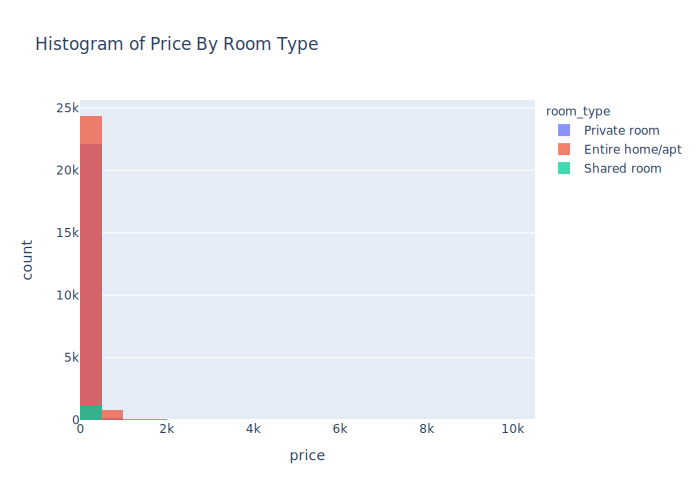

In [19]:
#Lets look at prices based on room type

fig = px.histogram(ny_df, x="price", color="room_type", nbins=30, title='Histogram of Price By Room Type')
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))


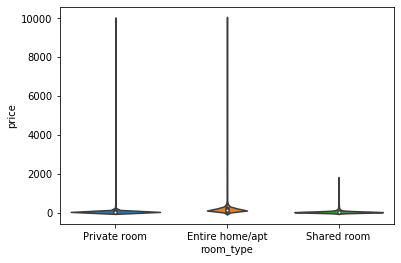

In [20]:
ax = sns.violinplot(x="room_type", y="price", data=ny_df)


We can see that the higher prices are outliers in the dataset. For more information on the bottom 90%, and a less skewed plot, see the other notebook. 

### Minimum_nights EDA

Minimum_nights refers to the minimum number of nights that must be booked. It is not obvious how this will impact the per night price; however, longer stays might have a lower per night cost due to economies of scale. 

First, lets look at the distrbution of minimum nights in the data.

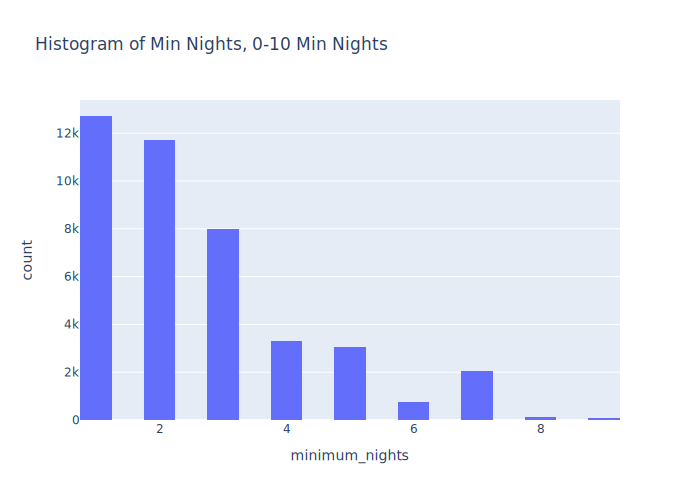

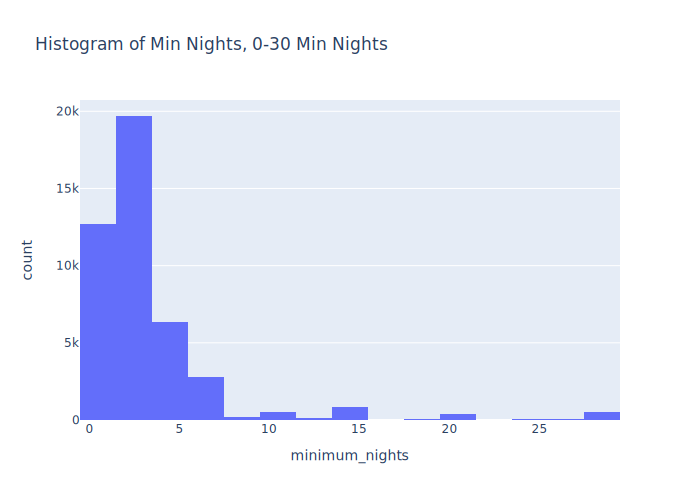

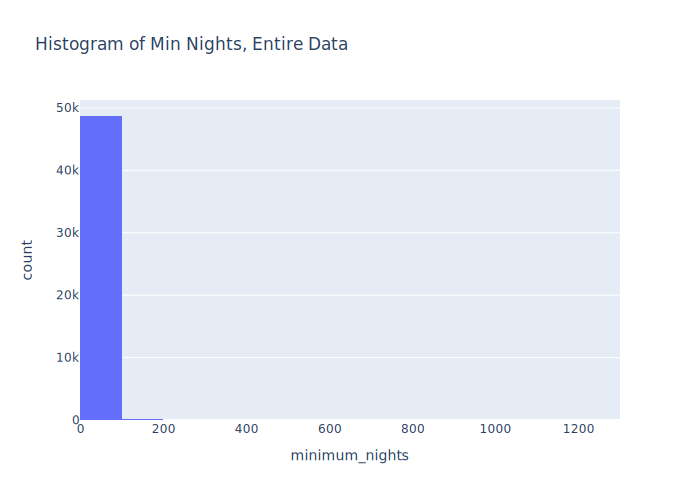

the mode is  0    1
dtype: int64
the median is  3.0
the mean is  7.029962163820431


In [21]:
fig = px.histogram(ny_df[ny_df["minimum_nights"]<10], x="minimum_nights", nbins=20, title='Histogram of Min Nights, 0-10 Min Nights')
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

fig = px.histogram(ny_df[ny_df["minimum_nights"]<30], x="minimum_nights", nbins=20, title='Histogram of Min Nights, 0-30 Min Nights')
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

fig = px.histogram(ny_df, x="minimum_nights", nbins=20, title='Histogram of Min Nights, Entire Data')
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

print('the mode is ', ny_df["minimum_nights"].mode())
print('the median is ', ny_df["minimum_nights"].median())
print('the mean is ', ny_df["minimum_nights"].mean())








This column is highly skewed, with a few properties having minimum_nights set to over two years. The median is 2 nights and the vast majority are below a week. 

### Longitude/Latitude EDA 

Latitude and longitude describe the exact location of each Airbnb. Since Manhattan has lower longitudinal coordinates, I expect there will be a relationship there.

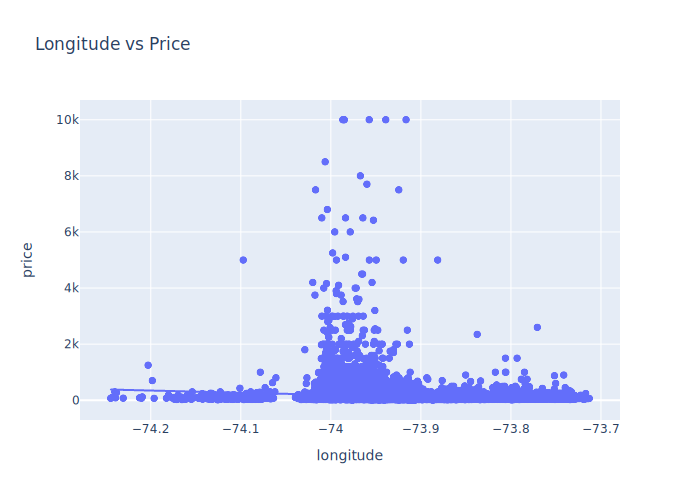

In [22]:
#Lets look at prices based on latitude (note that Mahattan has greater Longitude values than Brooklyn/Williamsburg)

fig = px.scatter(ny_df, x="longitude", y="price", title='Longitude vs Price', trendline='ols')
results = px.get_trendline_results(fig)
results = px.get_trendline_results(fig)
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

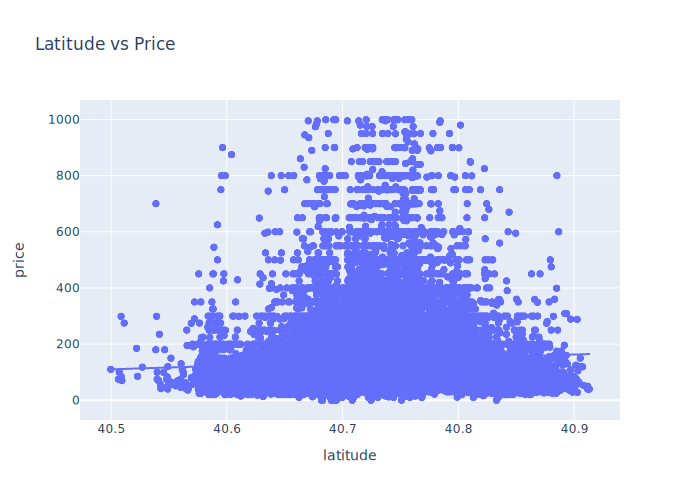

In [23]:
#Lets look at prices based on latitude (note that Mahattan has higher latitude values)

fig = px.scatter(ny_df[ny_df["price"]<1000], x="latitude", y="price", title='Latitude vs Price', trendline='ols')
results = px.get_trendline_results(fig)
results = px.get_trendline_results(fig)
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

When all of the price data is included, it is difficult to tease out the relationships between longitude and latitude. There appears to be a slight negative correlation between longitude and price and a slight positive correlation between latitude and price. 

### Neighborhood EDA

It would make sense that the different neighborhood groups would have different price distribitions. I would expect Manhattan to be the most expensive, and possibly Brooklyn as second most expensive.

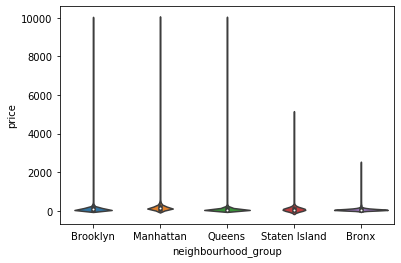

In [24]:
ax = sns.violinplot(x="neighbourhood_group", y="price", data=ny_df)

It appears that most of the most expensive properties are in Brooklyn Manhattan and Queens. Again, it is difficult to tease out trends with such extreme price values in the distribition. 

### Room Type and Neighborhood Maps

For room type and neighborhood maps, lets just look at prices about 250. The maps are less informative when all of the prices are included.

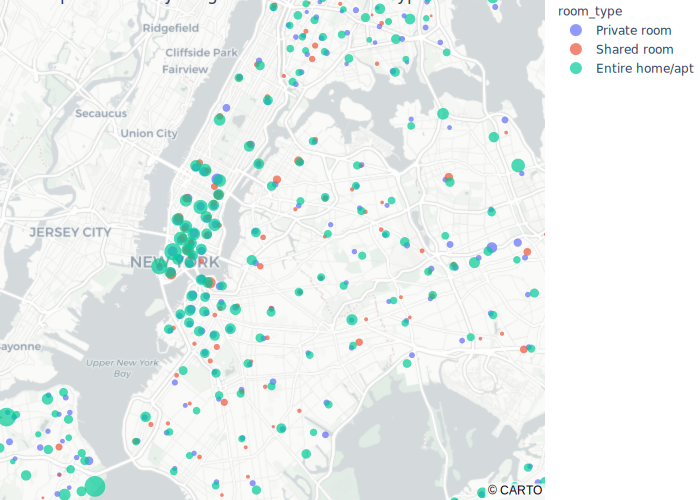

In [25]:
#Map looking at most expensive neighborhoods

neighborhoods=ny_df.groupby(["neighbourhood", "room_type"])[["price", "latitude", "longitude", "minimum_nights"]].mean().reset_index()
neighborhoods.sort_values('price', ascending=False, inplace=True)
rich_neighborhoods=neighborhoods


fig = px.scatter_mapbox(rich_neighborhoods, lat="latitude", lon="longitude",  size="price", color="room_type", size_max=15, zoom=10, hover_name="neighbourhood", hover_data=["price", "minimum_nights"], title="Map of Prices By Neighborhood and Roomtype")
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

It might be helpful to see which neighborhoods tend to have more expensive listings. Lets assign color to price. Again, lets focus on prices above 250.

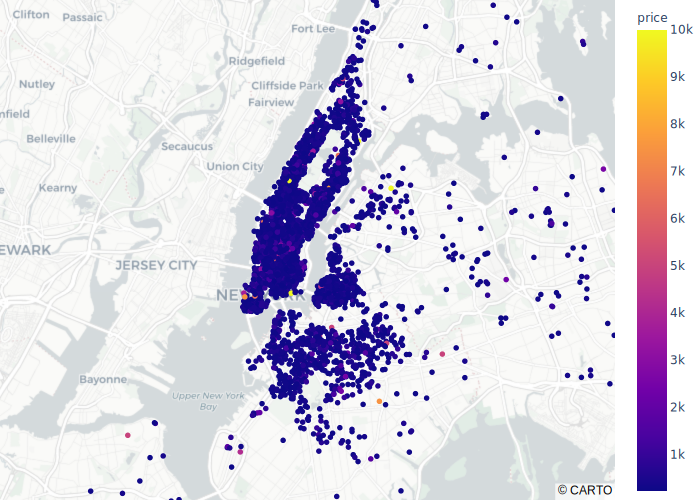

In [26]:
#Maps looking at prices for each Airbnb 


fig = px.scatter_mapbox(ny_df[ny_df["price"]>250], lat="latitude", lon="longitude",  color="price", size_max=15, zoom=10)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

To understand where the neighborhood group borders are, lets visualize them on a map. 

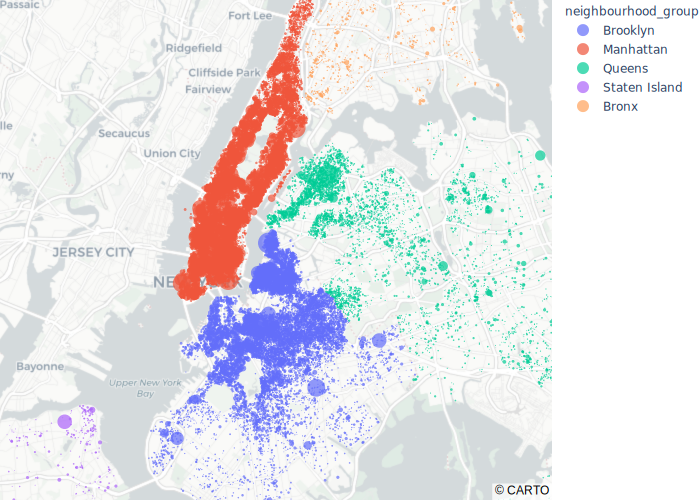

In [27]:
#Neighborhood Group Map
fig = px.scatter_mapbox(ny_df, lat="latitude", lon="longitude",  color="neighbourhood_group", size="price", size_max=15, zoom=10)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))


## Modelling 

The models run in this section include linear regression, lasso/ridge regression, decision tree regressor, random forest regressor, and a neural network. Again, this is modelling done on prices below $250 from the original data. 

In [28]:
#Checking the median and mean price
print(ny_df["price"].median())
print(ny_df["price"].mean())

106.0
152.7206871868289


We can see the mean of price of the whole dataset is $152 dollars. The bottom 90 percent has a mean of $107. 

### A Little More Preprocessing and Added Features

Lets one hot encode room_type, neighborhood_group, and neighborhood. I'll also add a new feature for distance from midtown, since the EDA suggested that a lot of more expensive properties are near Midtown. Note, name is still in the dataframe-- I'll address this later on. 

In [29]:
#adding dummies for roomtype
room_type_dummies=pd.get_dummies(ny_df['room_type'], prefix='room_type', drop_first=False).reset_index()
room_type_dummies.drop("index", axis=1, inplace=True)
ny_df_added_features = pd.concat([room_type_dummies, ny_df], axis=1)

#adding dist_from_midtown feature. After doing EDA on prices and location, a lot of the higher prices appeared to be very close to midtown. Lets construct a feature for this.
ny_df_added_features["dist_from_midtown"]=abs(ny_df_added_features["latitude"]-40.7069)+abs(ny_df_added_features["latitude"]+74.0031)

#adding dummies for neighborhood group
ny_df_added_features = pd.concat([ny_df_added_features ,pd.get_dummies(ny_df_added_features['neighbourhood_group'], prefix='neighbourhood_group', drop_first=False)],axis=1)

#adding dummies for neighborhood
ny_df_added_features = pd.concat([ny_df_added_features ,pd.get_dummies(ny_df_added_features['neighbourhood'], prefix='neighbourhood', drop_first=True)],axis=1)




In [30]:
#Dropping the original columns we just one hot encoded
ny_df_added_features.drop(["neighbourhood_group", "neighbourhood", "room_type", "host_id", "host_name", "id"], axis=1, inplace=True)

In [31]:
ny_df_added_features.head()

room_type_Entire home/apt  room_type_Private room  room_type_Shared room  \
0                          0                       1                      0   
1                          1                       0                      0   
2                          0                       1                      0   
3                          1                       0                      0   
4                          1                       0                      0   

                                               name  latitude  longitude  \
0                Clean & quiet apt home by the park  40.64749  -73.97237   
1                             Skylit Midtown Castle  40.75362  -73.98377   
2               THE VILLAGE OF HARLEM....NEW YORK !  40.80902  -73.94190   
3                   Cozy Entire Floor of Brownstone  40.68514  -73.95976   
4  Entire Apt: Spacious Studio/Loft by central park  40.79851  -73.94399   

   minimum_nights  number_of_reviews  reviews_per_month  \
0               1                  9               0.21   
1               1                 45               0.38   
2               3                  0               0.00   
3               1                270               4.64   
4              10                  9               0.10   

   calculated_host_listings_count  ...  neighbourhood_Westerleigh  \
0                               6  ...                          0   
1                               2  ...                          0   
2                               1  ...                          0   
3                               1  ...                          0   
4                               1  ...                          0   

   neighbourhood_Whitestone  neighbourhood_Williamsbridge  \
0                         0                             0   
1                         0                             0   
2                         0                             0   
3                         0                             0   
4                         0                             0   

   neighbourhood_Williamsburg  neighbourhood_Willowbrook  \
0                           0                          0   
1                           0                          0   
2                           0                          0   
3                           0                          0   
4                           0                          0   

   neighbourhood_Windsor Terrace  neighbourhood_Woodhaven  \
0                              0                        0   
1                              0                        0   
2                              0                        0   
3                              0                        0   
4                              0                        0   

   neighbourhood_Woodlawn  neighbourhood_Woodrow  neighbourhood_Woodside  
0                       0                      0                       0  
1                       0                      0                       0  
2                       0                      0                       0  
3                       0                      0                       0  
4                       0                      0                       0  

[5 rows x 238 columns]

In [32]:
#Splitting data into remainder (train and validation) and test split of 20% (calling X datarame "no words" because I haven't count vectorized the name column yet).

#I want all the columns except price in my X dataframe
X=ny_df_added_features.loc[:, ny_df_added_features.columns != 'price']

#Price is the target
y=ny_df_added_features["price"]
split = 0.2
X_remainder_no_words, X_test_no_words, y_remainder, y_test = train_test_split(X, y, test_size=split, random_state=6)
for i in [X_remainder_no_words, X_test_no_words, y_remainder, y_test]:
    print(i.shape)



(39116, 237)
(9779, 237)
(39116,)
(9779,)


In [33]:
#Resettig axis and dropping index columns
X_remainder_no_words=X_remainder_no_words.reset_index()
X_remainder_no_words.drop("index", axis=1, inplace=True)

y_remainder=y_remainder.reset_index()
y_remainder.drop("index", axis=1, inplace=True)


X_test_no_words=X_test_no_words.reset_index()
X_test_no_words.drop("index", axis=1, inplace=True)

y_test=y_test.reset_index()
y_test.drop("index", axis=1, inplace=True)

Now that most of the preprocessing is done, let's check a scaled linear regression to see which columns are having the most effect on price. Note I am not scaling one hot encoded columns, only the continuous ones.

In [34]:
#Scaling X data so we can compare the effect different coefficients are having

X_remainder_no_words_scaled=X_remainder_no_words.copy()
X_test_no_words_scaled=X_test_no_words.copy()


scalerx = StandardScaler()
scalerx.fit(X_remainder_no_words_scaled[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']])
X_remainder_no_words_scaled[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']] = scalerx.transform(X_remainder_no_words_scaled[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']])
X_test_no_words_scaled[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']] = scalerx.transform(X_test_no_words_scaled[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']])





Based on outside research, common sense, and EDA, it seems like price would mainly be a function of the room_type and general neighborhood group. Lets see how much of the variation can be explained by only these factors. I use statsmodels here so that the pvalues can easily be seen along with the coefficient values.

In [35]:
#Baseline linear regression using scaled data so we can evaluate coefficients (not including latitude/longitude/dist_from_midtown)
X = X_remainder_no_words_scaled[[ "room_type_Private room",
"room_type_Shared room",
"neighbourhood_group_Manhattan",
"neighbourhood_group_Brooklyn",
"neighbourhood_group_Queens",
"neighbourhood_group_Staten Island"]]
y = y_remainder
X_withconstant = sm.add_constant(X)

# 1. Instantiate Model
myregression = sm.OLS(y,X_withconstant)

# 2. Fit Model (this returns a seperate object with the parameters)
myregression_results = myregression.fit()

# Looking at the summary
myregression_results.summary()
 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     602.9
Date:                Sun, 28 Jun 2020   Prob (F-statistic):               0.00
Time:                        12:02:21   Log-Likelihood:            -2.6693e+05
No. Observations:               39116   AIC:                         5.339e+05
Df Residuals:                   39109   BIC:                         5.339e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                               161.4608      7.665     21.066      0.000     146.438     176.484
room_type_Private room             -109.4679      2.318    -47.229      0.000    -114.011    -104.925
room_type_Shared room              -133.6027      7.546    -17.705      0.000    -148.393    -118.812
neighbourhood_group_Manhattan        77.4073      7.727     10.018      0.000      62.262      92.553
neighbourhood_group_Brooklyn         20.0264      7.724      2.593      0.010       4.887      35.166
neighbourhood_group_Queens            7.3099      8.213      0.890      0.373      -8.787      23.407
neighbourhood_group_Staten Island    18.1873     14.817      1.227      0.220     -10.855      47.230
==============================================================================
Omnibus:                    88309.861   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        836765751.934
Skew:                          21.409   Prob(JB):                         0.00
Kurtosis:                     718.243   Cond. No.                         20.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It looks like our R2 on the train plus validation is 0.085 (compared to 0.477 on the bottom 90%) with only including these regressors. We can see that having a private or shared room pulls down the price, and being in Manhattan increases the price. Note that I have dropped two categories (entire home and the Bronx), since only dropping one category resulted in a near zero eigenvalue (indicating very high multicollinearity). 

In [36]:
print(X_remainder_no_words.shape)
print(X_test_no_words.shape)
print(y_remainder.shape)
print(y_test.shape)

(39116, 237)
(9779, 237)
(39116, 1)
(9779, 1)


The main method of model comparison will be RMSE, the "root mean squared error" of our predictions from the actual values in the test set. It will also be helpful to visualize the errors as a histogram. I will define a function that will calculate the RMSE for any model.

In [37]:
#feed in the X_test dataframe, y_test, and the model
def get_errors(X, y_test, model):
    
    #predict the models 
    y_pred=model.predict(X)
    
    #create a dataframe to store the predictions, actual values, and errors
    y_test_df=y_test.copy()
    
    #add predictions to the dataframe
    y_test_df["pred"]=y_pred
    
    #add the squared error of each prediction from the actual value to the dataframe
    y_test_df["error"]=(y_test_df["price"]-y_test_df["pred"])**(2)
    
    #add the absolute squared error to the dataframe
    y_test_df["abs_error"]=abs((y_test_df["price"]-y_test_df["pred"]))


    #take the square root of the sum of the squared error column of the dataframe to get RMSE
    print(f'RMSE={(((y_test_df["error"].sum()))/len(y_test_df))**(1/2)}')
    
    #Plot the absolute errors in a histogram
    fig=px.histogram(x=y_test_df['abs_error'], title="Abs Error", nbins=30)


    img_bytes = pio.to_image(fig, format="svg")
    display(SVG(img_bytes))

Now lets try a regression with all of the continuous data plus the room_type one hot encoded and neighbourhood group one hot encoded. This regression includes 14 features. 

### Linear Regression 1 (LR1)

In [52]:
#Try linear model using continuous data plust one hot encoded data for room_type and neighborhood_group


X_remainder_baseline=X_remainder_no_words[['room_type_Private room', 'room_type_Shared room', 'latitude', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365', 'dist_from_midtown', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island']]
X_test_baseline=X_test_no_words[['room_type_Private room', 'room_type_Shared room', 'latitude', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365', 'dist_from_midtown', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island']]


# 1. Instantiate the model
linear_regression_model = LinearRegression()

# 2. Fit the model
linear_regression_model.fit(X_remainder_baseline, y_remainder)

#The intercept
intercept = linear_regression_model.intercept_

#The coefficient, notice it returns an array with one spot for each feature
coefficient = linear_regression_model.coef_


model_prediction_train = linear_regression_model.predict(X_remainder_baseline)
model_prediction_test = linear_regression_model.predict(X_test_baseline)



# Evaluate the model on each set
print(f'The R2 score on the training set: {r2_score(y_remainder,model_prediction_train)}')
print(f'The R2 score on the testing set: {r2_score(y_test,model_prediction_test)}')

print(f'The RMSE score on the training set: {(mean_squared_error(y_remainder,model_prediction_train))**(1/2)}')
print(f'The RMSE score on the testing set: {(mean_squared_error(y_test,model_prediction_test))**(1/2)}')





#looks like we are massively overfitting- negative R2 on test 

The R2 score on the training set: 0.10507826991440716
The R2 score on the testing set: 0.09049610788096552
The RMSE score on the training set: 220.07449403948752
The RMSE score on the testing set: 255.66346867796045


We can see that the R2 has increased from 0.08 to 0.105 on the training set, meaning that more of the variation can be explained with the added regressors. From now on, lets pay attention to the RMSE on the test set as the main metric of model accuracy. This model has an RMSE of 255 on the test.

Now lets add the neighbourhood one hot encoding to the linear regression. This will bring our feautes up to over 200 since there are many neighbourhoods. Lets see what happens with the RMSE with these added regressors.

### Linear Regression 2 (LR2)

In [38]:
X_remainder_added=X_remainder_no_words.loc[:, X_remainder_no_words.columns != 'name']
X_test_added=X_test_no_words.loc[:, X_test_no_words.columns != 'name']

# 1. Instantiate the model
linear_regression_model = LinearRegression()

# 2. Fit the model
linear_regression_model.fit(X_remainder_added, y_remainder)

#The intercept
intercept = linear_regression_model.intercept_

#The coefficient, notice it returns an array with one spot for each feature
coefficient = linear_regression_model.coef_


model_prediction_train = linear_regression_model.predict(X_remainder_added)
model_prediction_test = linear_regression_model.predict(X_test_added)



# Evaluate the model on each set
print(f'The R2 score on the training set: {r2_score(y_remainder,model_prediction_train)}')
print(f'The R2 score on the testing set: {r2_score(y_test,model_prediction_test)}')

print(f'The RMSE score on the training set: {(mean_squared_error(y_remainder,model_prediction_train))**(1/2)}')
print(f'The RMSE score on the testing set: {(mean_squared_error(y_test,model_prediction_test))**(1/2)}')



#looks like we are massively overfitting- negative R2 on test 

The R2 score on the training set: 0.12064130773757153
The R2 score on the testing set: -91344249875.27753
The RMSE score on the training set: 218.15251075181314
The RMSE score on the testing set: 81022754.33176492


It looks like the neighborhood one hot encoding caused overfitting to happen given the negative R^2. Let's try a ridge and lasso to help correct for this.

RMSE=81022754.33176492


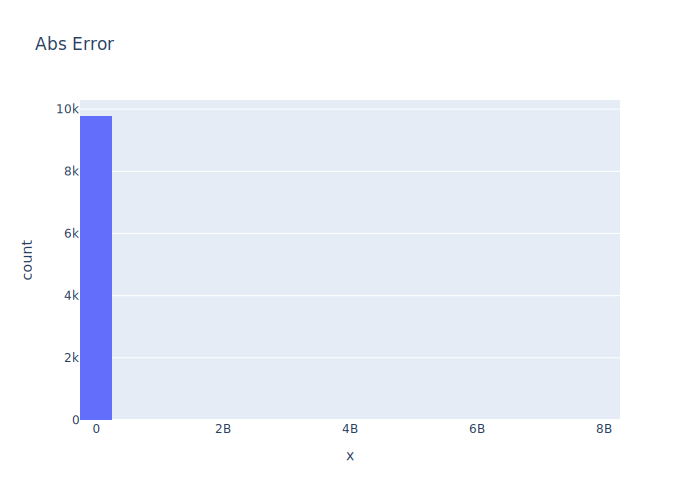

In [39]:
get_errors(X_test_added, y_test, linear_regression_model)

In [40]:
print(X_remainder_added.shape)
print(X_test_added.shape)
print(y_remainder.shape)
print(y_test.shape)





(39116, 236)
(9779, 236)
(39116, 1)
(9779, 1)


Now lets count vectorize the name column so the model can use this information. 

In [41]:
#Now looking at the count vectorized name data 


# 1. Instantiate, setting min_df to 10 which means that the minimum times the word must appear in the corpus is 10
bagofwords = CountVectorizer(min_df=10)

# 2. Fit 
bagofwords.fit(X_remainder_no_words["name"])

# 3. Transform 
X_remainder_bagofwords = bagofwords.transform(X_remainder_no_words["name"])
X_test_bagofwords = bagofwords.transform(X_test_no_words["name"])




In [42]:
#Adding the bag of words data to a dataframe from the array that the transform method produced
bagofwords.get_feature_names()
X_remainder_bagofwords.toarray()
X_test_bagofwords.toarray()


bag_of_words_train = pd.DataFrame(columns=bagofwords.get_feature_names(), data=X_remainder_bagofwords.toarray())
bag_of_words_test = pd.DataFrame(columns=bagofwords.get_feature_names(), data=X_test_bagofwords.toarray())




In [43]:
#Now we concat the count vectorized words to our X dataframes to get X_added_features
X_remainder_added_features=pd.concat([bag_of_words_train, X_remainder_no_words], axis=1)
X_test_added_features=pd.concat([bag_of_words_test, X_test_no_words], axis=1)

print(X_remainder_added_features.shape)
print(X_test_added_features.shape)



(39116, 1350)
(9779, 1350)


In [44]:
X_remainder_added_features.drop(["name"], axis=1, inplace=True)
X_test_added_features.drop(["name"], axis=1, inplace=True)

In [45]:
print(X_remainder_added_features.shape)
print(X_test_added_features.shape)

(39116, 1349)
(9779, 1349)


### Lasso and Ridge Regressions 

Coefficients:
Lasso: [ 0. -0.  0. ... -0.  0. -0.]
Ridge: [[145.09695571   2.83043167  -1.83267877 ...  -4.29010759  22.59029602
    1.94031687]]

R-squared:
Lasso train: 0.11665228669569239
Ridge train: 0.20530122276382368
Lasso test: 0.10373691935335862
Ridge test: 0.16894267696252918
The RMSE score on the training set: 218.15251075181314
The RMSE score on the testing set: 81022754.33176492
Ridge Train and Test RMSE:
Ridge Train
RMSE=207.38553324379953


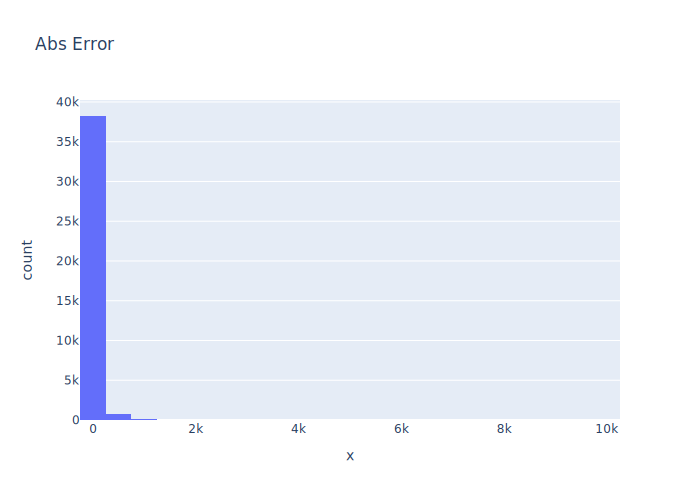

Ridge Test
RMSE=244.38913051498957


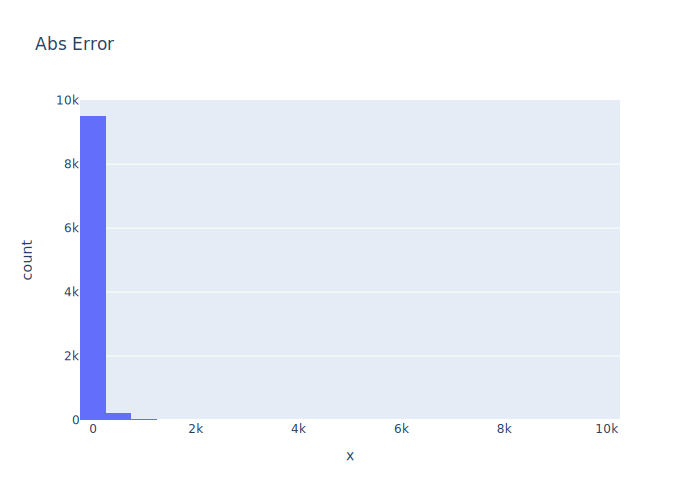

Lasso Train
RMSE=218.64675178782812


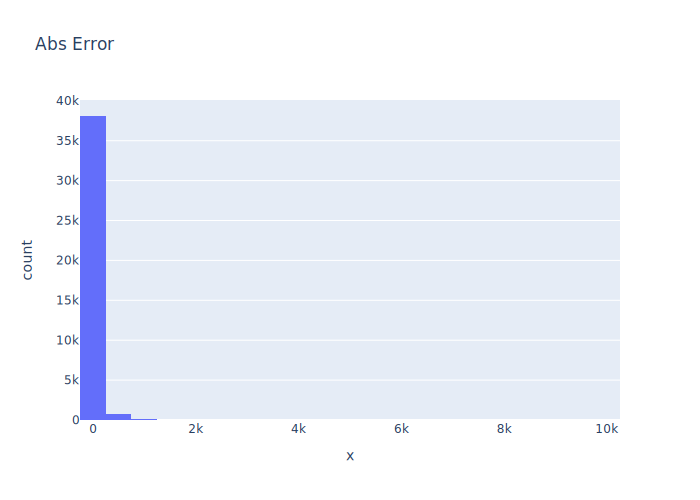

Lasso Test
RMSE=253.79563558325066


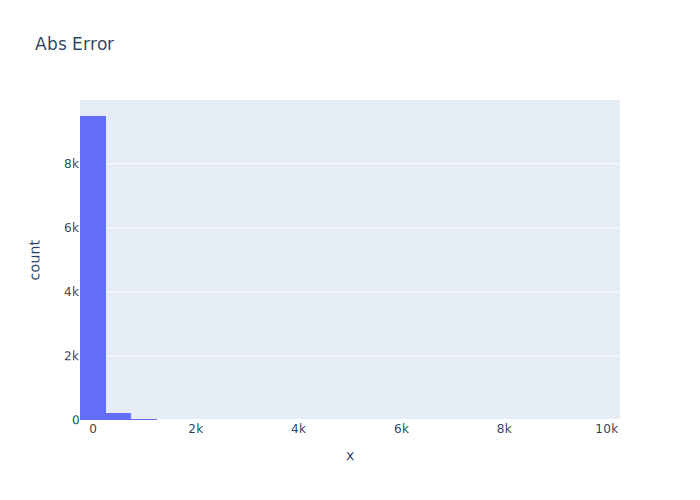

In [46]:


# Create the lasso and ridge models
lasso = Lasso()
lasso.fit(X_remainder_added_features,y_remainder)
ridge = Ridge(alpha=20)
ridge.fit(X_remainder_added_features,y_remainder)

print("Coefficients:")
print("Lasso:", lasso.coef_)
print("Ridge:", ridge.coef_)
print("")


# Compare R-squared
print("R-squared:")
print("Lasso train:", lasso.score(X_remainder_added_features,y_remainder))
print("Ridge train:", ridge.score(X_remainder_added_features,y_remainder))
print("Lasso test:", lasso.score(X_test_added_features,y_test))
print("Ridge test:", ridge.score(X_test_added_features,y_test))


print(f'The RMSE score on the training set: {(mean_squared_error(y_remainder,model_prediction_train))**(1/2)}')
print(f'The RMSE score on the testing set: {(mean_squared_error(y_test,model_prediction_test))**(1/2)}')

print("Ridge Train and Test RMSE:")

print("Ridge Train")
get_errors(X_remainder_added_features, y_remainder, ridge)

print("Ridge Test")
get_errors(X_test_added_features, y_test, ridge)


print("Lasso Train")
get_errors(X_remainder_added_features, y_remainder, lasso)

print("Lasso Test")
get_errors(X_test_added_features, y_test, lasso)

It looks like the RMSE went from 255 to 244 on the test set between the first linear model run and the ridge regression. Regularization seemed to help the overfitting problem that the second linear model had.

It would be interesting to see which words are most predictive of a higher prices and of a lower prices.

In [49]:
#Running a logistic regression of bag of words on price to see which words have the most predictive power

#Fit a logistic regression model
logreg_model = LogisticRegression()
logreg_model.fit(bag_of_words_train, y_remainder)

print(f'score on training: {logreg_model.score(X_remainder_bagofwords, y_remainder)}')
print(f'score on testing: {logreg_model.score(X_test_bagofwords, y_test)}')


bag_of_words_train.head()

score on training: 0.16862664894160956
score on testing: 0.0648328049902853


000  10  100  1000  107  10min  10mins  11  116  11th  ...  yoga  york  \
0    0   0    0     0    0      0       0   0    0     0  ...     0     0   
1    0   0    0     0    0      0       0   0    0     0  ...     0     0   
2    0   0    0     0    0      0       0   0    0     0  ...     0     0   
3    0   0    0     0    0      0       0   0    0     0  ...     0     0   
4    0   0    0     0    0      0       0   0    0     0  ...     0     0   

   yorker  you  young  your  yours  yourself  zen  zoo  
0       0    0      0     0      0         0    0    0  
1       0    0      0     0      0         0    0    0  
2       0    0      0     0      0         0    0    0  
3       0    0      0     1      0         0    0    0  
4       0    0      0     0      0         0    0    0  

[5 rows x 1113 columns]

In [50]:
#Getting list of indicies for the words
indicies=[]
for i in bag_of_words_train:
    index=bag_of_words_train.columns.get_loc(i)
    indicies.append(index)

#making a list of coefficients from the logistic regression    
coef_lst=logreg_model.coef_.tolist()

#merging indicies and coefficients into a list of tuple 
tuples=list(zip(indicies, coef_lst[0]))
tuples

#sorting the tuples 
def Sort_Tuple(tup):  
  
    # reverse = None (Sorts in Ascending order)  
    # key is set to sort using second element of  
    # sublist lambda has been used  
    tup.sort(key = lambda x: x[1], reverse=True)  
    return tup 

Sorted_words=Sort_Tuple(tuples)

indicies_2=[]
for i in Sorted_words:
    indicies_2.append(i[0])

words_sorted=bag_of_words_train.columns[indicies_2]

#Bottom 30 words 
for i in words_sorted[0:30]:
    print(i)

coliving
shared
room
brownstone
modern
yet
hostel
2nd
ideal
design
spacious
it
master
style
nice
all
comfortable
brooklyn
best
living
space
view
close
huge
bedroom
heart
williamsburg
loft
to
cozy


In [51]:
#redefine the sort function to sort in decending order  
def Sort_Tuple(tup):  
  
    # reverse = None (Sorts in Ascending order)  
    # key is set to sort using second element of  
    # sublist lambda has been used  
    tup.sort(key = lambda x: x[1])  
    return tup 

Reverse_Sorted_words=Sort_Tuple(tuples)

indicies_2=[]
for i in Reverse_Sorted_words:
    indicies_2.append(i[0])

words_sorted_reverse=bag_of_words_train.columns[indicies_2]

#Top 30 predictive words of high price
for i in words_sorted_reverse[0:30]:
    print(i)

apt
manhattan
in
studio
and
sunny
beautiful
nyc
park
east
bed
near
village
luxury
large
bright
location
new
home
1br
central
for
midtown
west
one
duplex
charming
bath
clean
br


Some of the words here make sense, and some of them are less logical. For example, in the bottom 30 words, "coliving" and "hostel" are suggestive of cheaper prices, but "space" doesn't necessarily imply cheap. 
Looking at words most predictive of high prices, "manhattan" makes sense, while "cozy" is less suggestive. Overall, it seems like the count vectorized name should provide some additional predictive power for the model. These lists are quite similar to the bottom 90% of the data.

In [52]:
X_train_added_features, X_validation_added_features, y_train, y_validation = \
    train_test_split(X_remainder_added_features, y_remainder, test_size = 0.3,
                     random_state=1)

Lets try a decision tree regressor. I'll also use cross validation to select the correct max depth.

### Decision Tree Regressor (DT)

In [53]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

cross_validation_scores_val = []
cross_validation_scores_train = []




depths=range(1,10)
for depth in depths:
    tree = DecisionTreeRegressor(max_depth=depth)
    tree.fit(X_train_added_features, y_train)
    cv_score_val = np.mean(cross_val_score(tree, X_validation_added_features, y_validation, cv = 5))
    cross_validation_scores_val.append(cv_score_val)
    cv_score_train = np.mean(cross_val_score(tree, X_train_added_features, y_train, cv = 5))
    cross_validation_scores_train.append(cv_score_train)


    print(f'depth = {depth}')
    print(f"DT R^2 score on training set: {tree.score(X_train_added_features, y_train):0.3f}")
    print(f"DT R^2 score on validation set: {tree.score(X_validation_added_features, y_validation):0.3f}")
    


depth = 1
DT R^2 score on training set: 0.058
DT R^2 score on validation set: 0.064
depth = 2
DT R^2 score on training set: 0.093
DT R^2 score on validation set: 0.068
depth = 3
DT R^2 score on training set: 0.182
DT R^2 score on validation set: -0.213
depth = 4
DT R^2 score on training set: 0.291
DT R^2 score on validation set: -0.260
depth = 5
DT R^2 score on training set: 0.331
DT R^2 score on validation set: -0.988
depth = 6
DT R^2 score on training set: 0.375
DT R^2 score on validation set: -0.693
depth = 7
DT R^2 score on training set: 0.415
DT R^2 score on validation set: -0.336
depth = 8
DT R^2 score on training set: 0.529
DT R^2 score on validation set: -1.083
depth = 9
DT R^2 score on training set: 0.566
DT R^2 score on validation set: -0.750


Lets plot the validation and training scores and select the depeth with the highest validation.

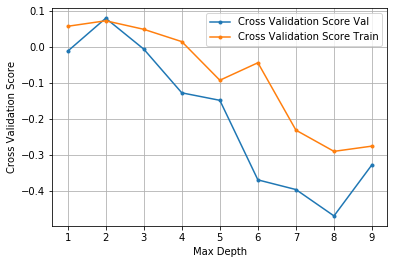

In [54]:
plt.figure()
plt.plot(depths, cross_validation_scores_val,label="Cross Validation Score Val",marker='.')
plt.plot(depths, cross_validation_scores_train,label="Cross Validation Score Train",marker='.')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show()

It looks like max depth of 2 performed the best on the cross validation scores. 

In [55]:
tree = DecisionTreeRegressor(max_depth=2)
tree.fit(X_train_added_features, y_train)
print(f'Validation score with optimal max depth of 2: {tree.score(X_validation_added_features, y_validation)}')
print(f'Test score with optimal max depth of 2: {tree.score(X_test_added_features, y_test)}')

Validation score with optimal max depth of 2: 0.06778572750988887
Test score with optimal max depth of 2: 0.06320026453933503


RMSE=259.47156758639215


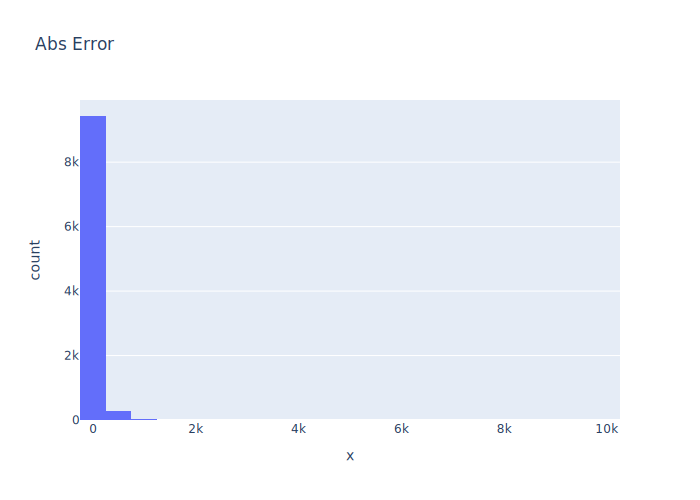

In [56]:
get_errors(X_test_added_features, y_test, tree)

With the whole price range, the optimized decision tree is actually worse than the first linear model in terms of RMSE. This could be the result of overfitting. 

Lets try a Random Forest to see if we can prevent overfitting.

### Random Forest Regressor (RFR)

In [57]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [1,2,3,4,5,6,7,8,9,10],
    'max_features': [1,2,3,4,5],
    'min_samples_leaf': [1,2,3,4,5],
    'min_samples_split': [1,2,3,4,5,6,7,8,9,10],
    'n_estimators': [10,20,30,100,200]
}

my_random_forest = RandomForestRegressor()

clf = GridSearchCV(my_random_forest, param_grid)

my_random_forest.fit(X_remainder_added_features, y_remainder.values.ravel())


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [58]:
my_random_forest.score(X_test_added_features, y_test)

0.2420640620186496

RMSE=233.39021594359997


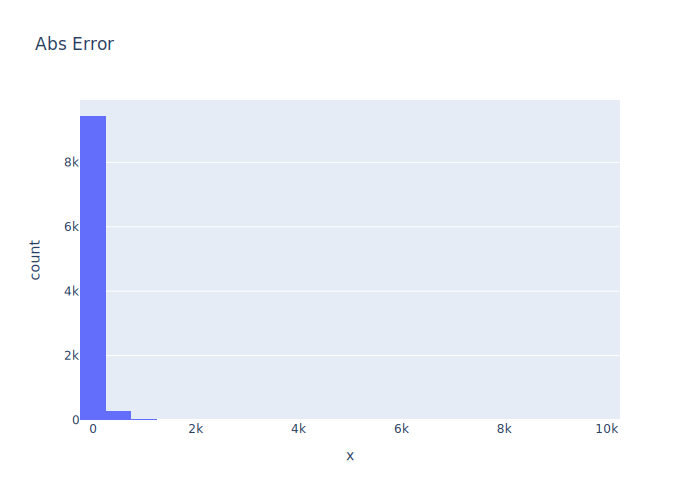

In [59]:
get_errors(X_test_added_features, y_test, my_random_forest)

### Gradient Boosting Regressor (GBR)

In [60]:
param_grid = {
    'max_depth': [1,2,3,4,5,6,7,8,9,10],
    'max_features': [180],
    'min_samples_leaf': [1,2,3,4,5],
    'min_samples_split': [1,2,3,4,5,6,7,8,9,10],
    'n_estimators': [10,20,30,100,200],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1]
}

gb_model = GradientBoostingRegressor()

clf = GridSearchCV(gb_model, param_grid)

gb_model.fit(X_remainder_added_features, y_remainder.values.ravel())

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [61]:
gb_model.score(X_test_added_features, y_test)

0.23710717461778266

RMSE=234.15215611210178


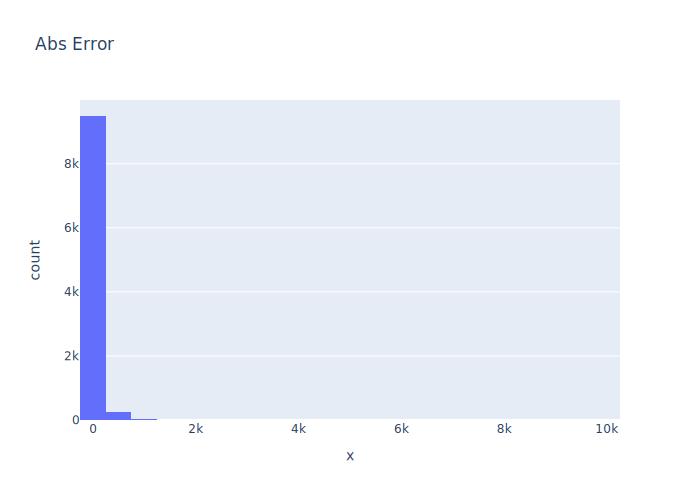

In [62]:
get_errors(X_test_added_features, y_test, gb_model)

In [63]:
#Scaling data for KNN (only scaling continuous data and not the one hot encoded data)

In [64]:
from sklearn.preprocessing import StandardScaler

scalerx = StandardScaler()
scalerx.fit(X_train_added_features[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']])
X_train_added_features[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']] = scalerx.transform(X_train_added_features[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']])
X_validation_added_features[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']] = scalerx.transform(X_validation_added_features[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']])
X_test_added_features[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']] = scalerx.transform(X_test_added_features[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']])
X_remainder_added_features[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']] = scalerx.transform(X_remainder_added_features[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']])



Next, lets try a KNN Regressor. (warning: the cell below takes a very long time to run )

### KNN Regressor 

In [65]:
# Check if the model results file already exists
if os.path.exists('models/knn_regressor_whole_data.pkl'):
    results = joblib.load('models/knn_regressor_whole_data.pkl')

    print("We already ran the model once! Here are the results:")
    print(f"RMSE: {results['RMSE']}")
    print(f"best params: {results['best_params']}")


# If it doesn't exist, run our model and save the results
else:

  # Store our results in a dictionary
    results = dict()
    


    param_grid = {'n_neighbors':[2,3,4,5,6,7,8,9]}

    KNN = KNeighborsRegressor()

    KNN_model = GridSearchCV(KNN, param_grid, cv=5)
    KNN_model.fit(X_remainder_added_features,y_remainder)
    results['prediction'] = KNN_model.predict(X_test_added_features)
    results['score'] = KNN_model.score(X_test_added_features,y_test)
    results['best_params']=KNN_model.best_params_
    results['MSE']=(results['prediction']-y_test)**2
    results['RMSE']=(results['MSE'].sum()/len(y_test))**(1/2)
# make model directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save results to file
joblib.dump(results, 'models/knn_regressor_whole_data.pkl')    

We already ran the model once! Here are the results:
RMSE: price    246.208768
dtype: float64
best params: {'n_neighbors': 9}


['models/knn_regressor_whole_data.pkl']

In [ ]:
#Lets try KNN 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


KNNmodel = KNeighborsRegressor(weights='distance', n_neighbors=2)
KNNmodel.fit(X_train_added_features, scaled_y_remainder)

print(f"R^2 score on training set: {KNNmodel.score(X_train_added_features, scaled_y_remainder)}")
print(f"R^2 score on test set: {KNNmodel.score(X_test_added_features, scaled_y_test)}")

In [ ]:
get_errors(X_test_added_features, y_test, KNN_model)

### Neural Network 

In [ ]:
y_train_scaled=np.log10(y_train+1)
y_test_scaled=np.log10(y_test+1)
y_validation_scaled=np.log10(y_validation+1)

In [ ]:
y_train_scaled.head()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
#from tensorflow.metrics import RootMeanSquaredError
model = Sequential([
    Dense(512, activation='relu', input_shape=(1347,)),
    Dense(512),
    Dense(1),
])


model.compile(
              loss='mse', optimizer='adam')

hist = model.fit(X_train_added_features, y_train, epochs=15,
          batch_size=64,
          validation_data=(X_validation_added_features, y_validation))



In [ ]:
print(hist.history.keys())

In [ ]:
hist.history['loss'][1:]

In [ ]:
# list all data in history
print(hist.history.keys())

# summarize history for loss
plt.plot(hist.history['loss'][1:])
plt.plot(hist.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(X_val.shape)
print(y_validation.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
y_pred_log=model.predict(X_test_added_features)
y_pred_normal=(10**y_pred_log)-1
y_test_df=y_test.copy()
y_test_df["pred"]=y_pred_normal
y_test_df["abs_error"]=np.abs(y_test_df["pred"]-y_test_df["price"])
RMSE=((((y_test_df["price"]-y_test_df["pred"])**(2))/len(y_test_df)).sum())**(1/2)

print(f'RMSE: {RMSE}')
fig=px.histogram(x=y_test_df['abs_error'], nbins=30)


fig.show()


In [ ]:
get_errors(X_test_added_features, y_test, model)

### Results 

LR2 isn't included due to it's extremely high RMSE.

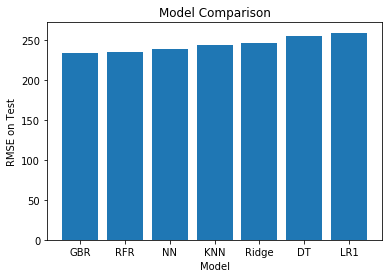

In [47]:
RMSE=[255, 244, 259, 235, 234, 239, 246]
RMSE=sorted(RMSE)

plt.figure()
plt.bar(x=["GBR", "RFR", "NN", "KNN", "Ridge", "DT", "LR1"], height=RMSE)
plt.xlabel("Model")
plt.ylabel("RMSE on Test")
plt.title("Model Comparison")
plt.show()